In [1]:
import numpy as np
np.set_printoptions(suppress=True)
from typing import List, Dict
import random
import itertools
import argparse
from scipy.stats import entropy
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import os
from scipy import stats
import glob
import copy
from tqdm import tqdm
from scipy.special import softmax
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
torch.set_printoptions(sci_mode=False)
import multiprocessing as mp
from collections import Counter
import pickle
import json
import scipy.linalg as la
from numpy.linalg import eig
from environments.rps_enivronment import GMMAgent, GMMAgent_nash, TorchPop, TorchPop_nash
from utils.meta_solver import meta_solver_with_invariant_small
from utils.utils import load_trained_model, gen_labels, fictitious_play

parser = argparse.ArgumentParser(description='2D-RPS')
parser.add_argument('--job_number', type=int, default=1)
parser.add_argument('--num_test_games', type=int, default=1)
parser.add_argument('--psro_iters', type=int, default=20)
parser.add_argument('--num_mode', type=int, default=7)
parser.add_argument('--job_name', type=str, default='2d_rps_test')
args = parser.parse_args(args=[])

PATH_RESULTS = os.path.join('results' , args.job_name + '_job_' + str(args.job_number) + '_mode_' + str(args.num_mode))
if not os.path.exists(PATH_RESULTS):
    os.makedirs(PATH_RESULTS)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import os
from scipy import stats
import pickle
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
np.random.seed(0)
from numpy.random import RandomState
import scipy.linalg as la

import copy
from scipy.linalg import circulant
torch.set_printoptions(sci_mode=False)
from environments.rps_enivronment import GMMAgent_nash, TorchPop_nash
from utils.utils import fictitious_play

device = 'cpu'

def gradient_loss_update(torch_pop, k, train_iters=10, lr=0.1):

    # We compute metagame M and then L in a differentiable way
    # We compute expected payoff of agent k-1 against aggregated strat

    # Make strategy k trainable
    torch_pop.pop[k].x.requires_grad = True

    # Optimiser
    optimiser = optim.SGD(torch_pop.pop[k].parameters(), lr=lr)

    for iters in range(train_iters):

        # Get metagame and metastrat
        M = torch_pop.get_metagame(k=k+1)
        meta_nash = fictitious_play(payoffs=M.detach().cpu().clone().numpy()[:k, :k], iters=1000)[0][-1]

        # Compute the expected return given that enemy plays agg_strat (using :k first strats)
        exp_payoff = torch_pop.get_payoff_aggregate(torch_pop.pop[k], meta_nash, k)
        #print(exp_payoff)
        #print(f'On iter {iter} the expected payoff is {exp_payoff}')

        # Loss
        loss = -(exp_payoff)

        # Optimise !
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    torch_pop.pop_hist[k].append(torch_pop.pop[k].x.detach().cpu().clone().numpy())
    # Make strategy k non-trainable
    torch_pop.pop[k].x.detach()
    return exp_payoff.item()

def run_psro(torch_pop, model=None, iters=5, num_mode=3, lr=.2, train_iters=10, seed=0):

    metanash_list = []
    if model == None:
        #device = 'cuda:0'
        # Compute initial exploitability and init stuff
        metagame = torch_pop.get_metagame(numpy=True)
        metanash = fictitious_play(payoffs=metagame, iters=1000)[0][-1]
        metanash_list.append(metanash)
        metanash = torch.Tensor(metanash)
        torch_pop.add_new()
        torch_pop.pop[-1].x.requires_grad = True
        exps = []

        for psro_iters in range(iters):

            for i in range(train_iters):

                # Diverse PSRO
                exp_payoff = torch_pop.get_payoff_aggregate(torch_pop.pop[-1], metanash, len(metanash))
                loss = -(exp_payoff)

                psro_grad = torch.autograd.grad(loss, torch_pop.pop[-1].x, create_graph=False)
                torch_pop.pop[-1].x = torch_pop.pop[-1].x - lr * psro_grad[0]

                torch_pop.pop[-1].x.detach()

            metagame = torch_pop.get_metagame(numpy=True)
            metanash = fictitious_play(payoffs=metagame, iters=1000)[0][-1]
            metanash_list.append(metanash)
            metanash = torch.Tensor(metanash).to(device)
            exp = torch_pop.get_exploitability_test(metanash, 75, 0.5).item()
            print(exp)
            exps.append(exp)

            torch_pop.add_new()
            torch_pop.pop[-1].x.requires_grad = True

    else: 
        #device = 'cuda:0'
        # Compute initial exploitability and init stuff
        model.to(device)
        metagame = torch_pop.get_metagame()
        metagame = metagame[None,None,].to(device)
        metanash = model(metagame)[0]
        metanash_list.append(metanash.detach().cpu().numpy())
        exps = []
        torch_pop.add_new()
        torch_pop.pop[-1].x.requires_grad = True

        for psro_iters in range(iters):

            for i in range(train_iters):

                # Diverse PSRO
                exp_payoff = torch_pop.get_payoff_aggregate(torch_pop.pop[-1], metanash, len(metanash))
                loss = -(exp_payoff)

                psro_grad = torch.autograd.grad(loss, torch_pop.pop[-1].x, create_graph=False)
                torch_pop.pop[-1].x = torch_pop.pop[-1].x - lr * psro_grad[0]

            torch_pop.pop[-1].x.detach()

            metagame = torch_pop.get_metagame()
            metagame = metagame[None,None,].to(device)
            metanash = model(metagame)[0]
            metanash_list.append(metanash.detach().cpu().numpy())
            exp = torch_pop.get_exploitability_test(metanash, 50, 1.0).item()
            print(exp)
            exps.append(exp)

            torch_pop.add_new()
            torch_pop.pop[-1].x.requires_grad = True

    return torch_pop, metanash_list#exps

In [3]:
set_seed = np.random.randint(10000)

## Nash Visualization

In [4]:
model_list = []
model_list.append(None)

#model_list = [None]#test which model
mod_list = model_list
num_test_games = args.num_test_games
train_iters = args.psro_iters
num_mod = len(mod_list)


game_list = [[TorchPop(num_mode=args.num_mode, seed=(set_seed + i), resample_mu=True, test=True) for i in range(num_test_games)] for _ in range(num_mod)]
nash_game = [TorchPop(num_mode=args.num_mode, seed=(set_seed + i), resample_mu=True, test=True) for i in range(num_test_games)]
model_exps = [[] for _ in range(num_mod)]

for i, mod in enumerate(mod_list):
    print('model {}'.format(i))
    for j in tqdm(range(num_test_games)):
        if i == len(mod_list)-1:
            game = nash_game[j]  
        else:  
            game = game_list[i][j]
        torch_pop, meta_nash_list = run_psro(game, model=mod, iters=train_iters, num_mode=args.num_mode, lr=2, train_iters=5)
        break
    break
        #print(exps)
        #model_exps[i].append(exps)

model 0


  0%|                                                                                                                              | 0/1 [00:00<?, ?it/s]

0.8154350519180298
2.119255304336548
3.661407470703125
0.9011358022689819
0.42465534806251526
0.3218677043914795
0.32343414425849915
0.40030044317245483
0.321461021900177
0.37035542726516724
0.31527137756347656
0.49461957812309265
0.4163613021373749
0.3930186629295349
0.24251389503479004
0.4181942641735077
0.4464014172554016
0.38206931948661804
0.3634953498840332


  0%|                                                                                                                              | 0/1 [00:09<?, ?it/s]

0.3690548837184906


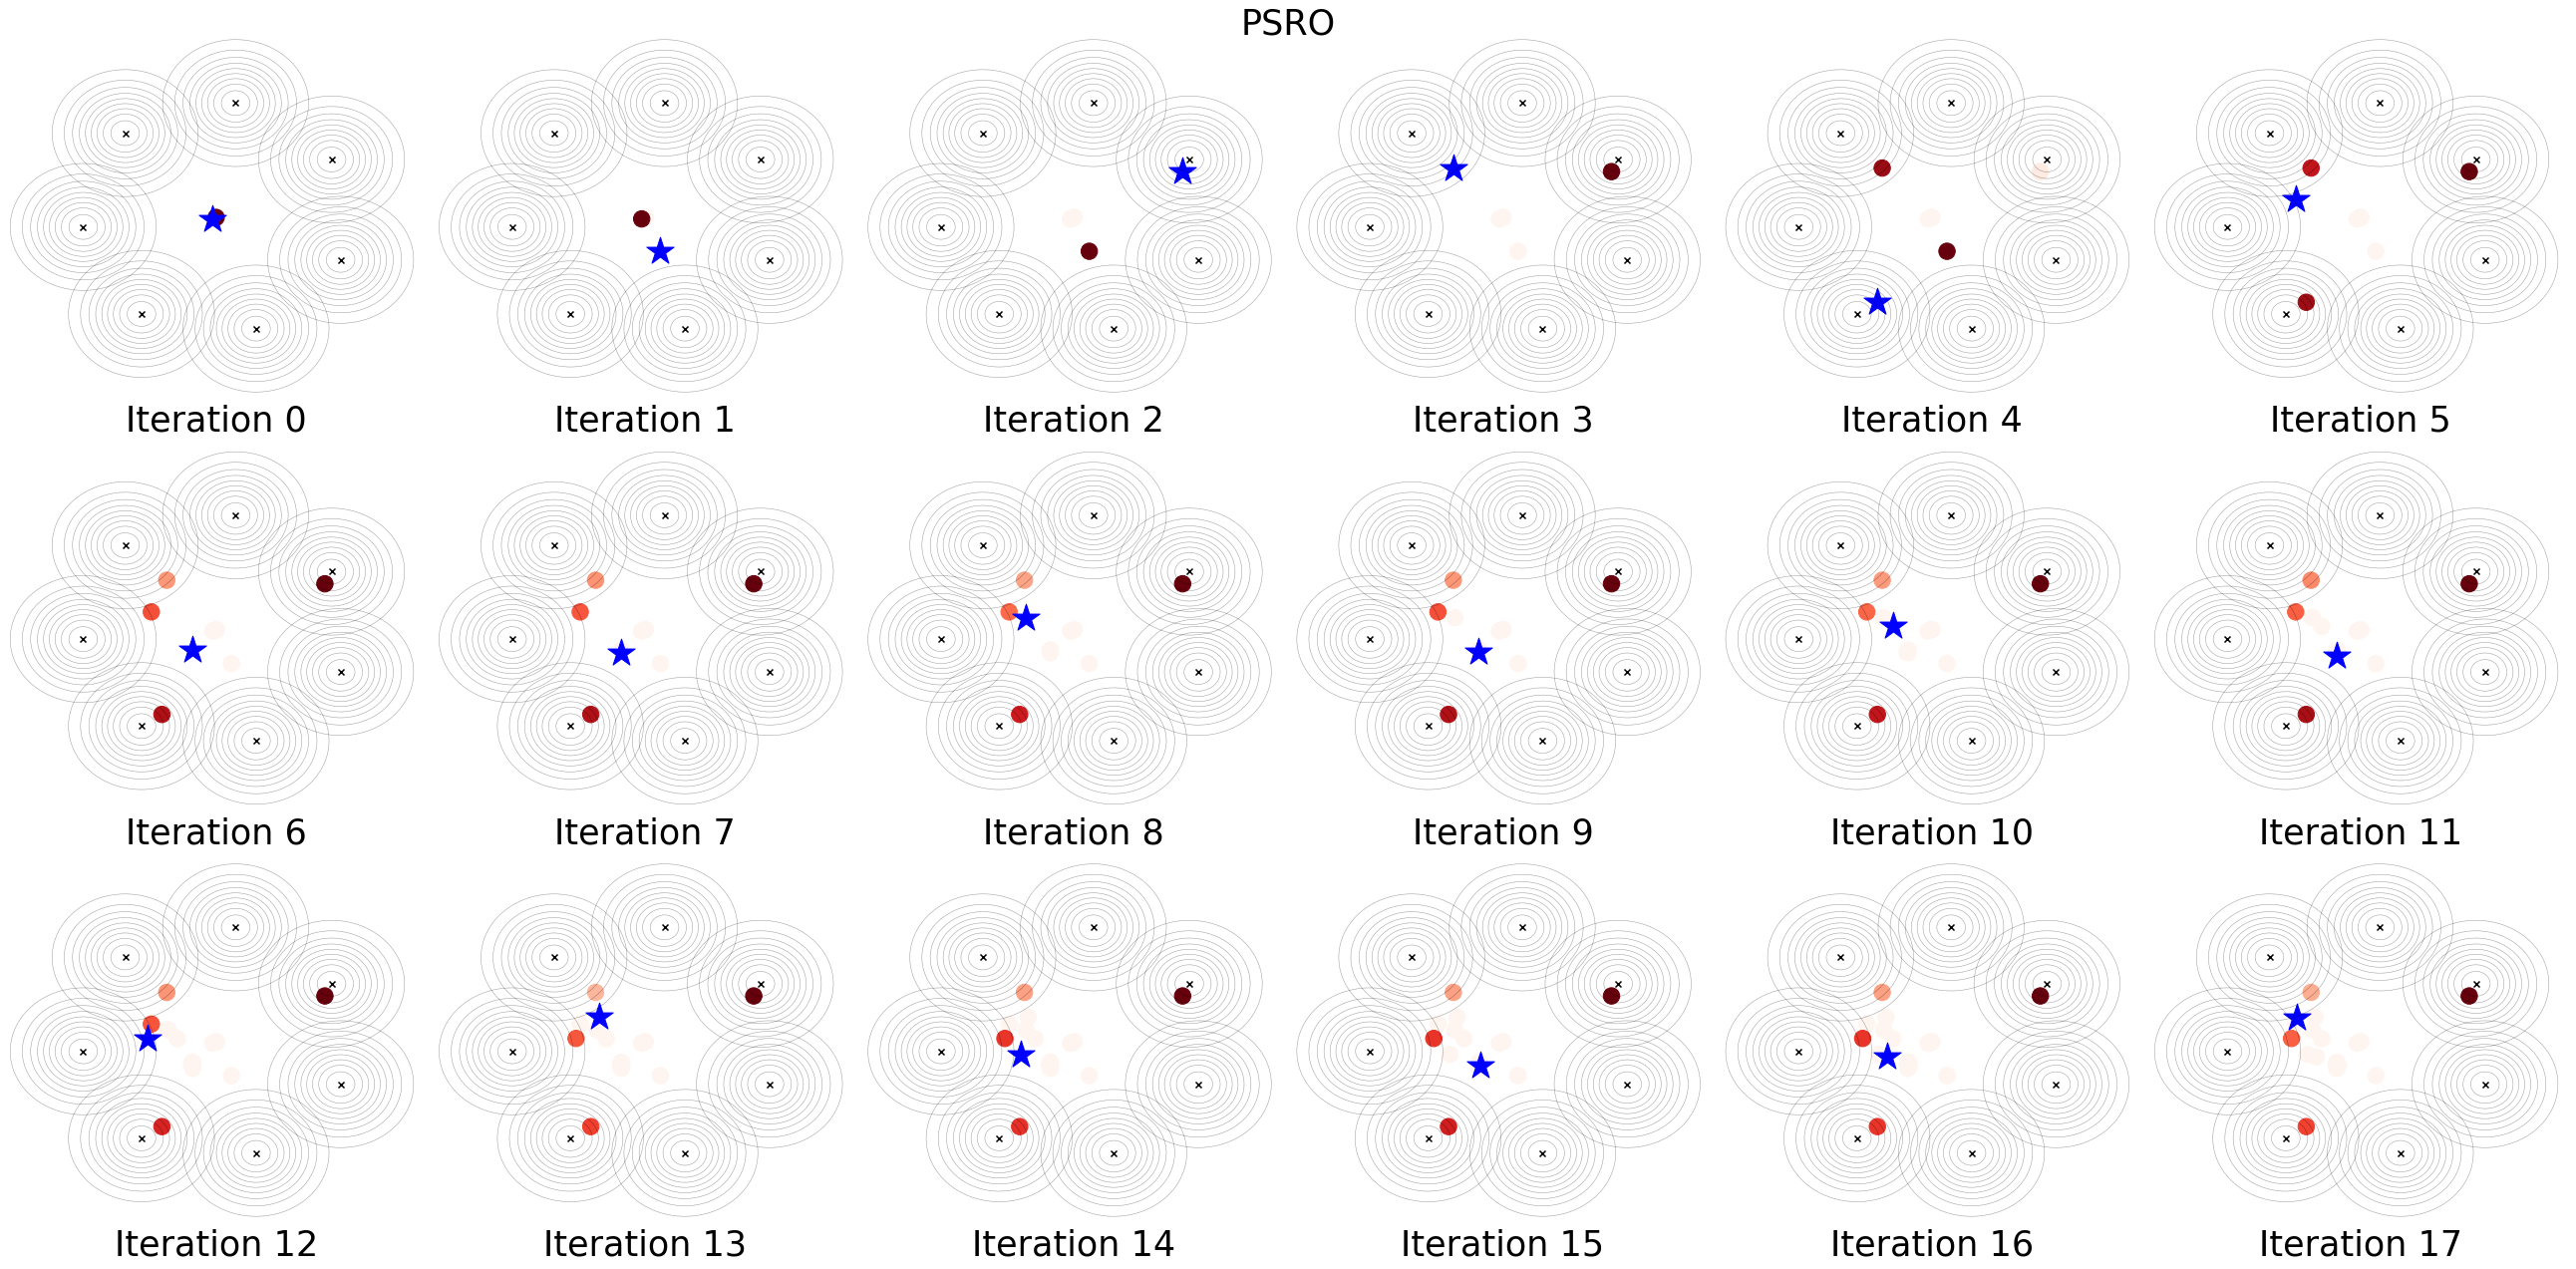

In [5]:
        
fig, axlist = plt.subplots(3, 6, figsize=(36,18))
iteration = [i for i in range(18)]#[1,4,7,10,13,16]
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2 * np.pi) ** n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos - mu, Sigma_inv, pos - mu)
    return np.exp(-fac / 2) / N

def draw(iters, ax):
    for i in range(7):
        ax.scatter(torch_pop.mus[i, 0].item(), torch_pop.mus[i, 1].item(), marker='x', c='k')
        for j in range(4):
            delta = 0.025
            x = np.arange(-4.5, 4.5, delta)
            y = np.arange(-4.5, 4.5, delta)
            X, Y = np.meshgrid(x, y)
            pos = np.empty(X.shape + (2,))
            pos[:, :, 0] = X
            pos[:, :, 1] = Y
            Z = multivariate_gaussian(pos, torch_pop.mus[i,:].cpu().numpy(), 0.54 * np.eye(2))
            levels = 10
            # levels = np.logspace(0.01, 1, 10, endpoint=True)
            CS = ax.contour(X, Y, Z, levels, colors='k', linewidths=0.5, alpha=0.1)
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
                # ax.clabel(CS, fontsize=9, inline=1)
                # circle = plt.Circle((0, 0), 0.2, color='r')
                # ax.add_artist(circle)
        ax.set_xlim([-4.5, 4.5])
        ax.set_ylim([-4.5, 4.5])
    label = 'timestep {0}'.format(iters)
    length = len(meta_nash_list[iters])
    agents = [agent.x.detach().cpu().numpy() for agent in torch_pop.pop[:length]]
    agents = list(zip(*agents))
    
    agents_new = [torch_pop.pop[length].x.detach().cpu().numpy()]
    agents_new = list(zip(*agents_new))
    # 更新线和坐标轴标签
    b = ax.scatter(agents[0], agents[1], alpha=1, marker='.', c=meta_nash_list[iters], cmap=plt.get_cmap('Reds'),  s=30*plt.rcParams['lines.markersize'] ** 2)
    #plt.colorbar(b)
    ax.scatter(agents_new[0], agents_new[1], alpha=1, marker='*', c='Blue',  s=23*plt.rcParams['lines.markersize'] ** 2)

    ax.set_xlabel('Iteration'+' '+str(iters), fontsize=35)

for i in range(len(axlist.flatten())):
    ax = axlist.flatten()[i]
    draw(iteration[i],ax)
fig.suptitle('PSRO',fontsize=35)
fig.tight_layout()
plt.savefig('./nash_2d_rps_all.pdf',bbox_inches="tight", pad_inches=0.04)
plt.show()

## LMAC Visualization

In [7]:
model_list = []
tmp_mod = meta_solver_with_invariant_small().cuda(0)
tmp_mod.load_state_dict(torch.load('../pretrain_model/step5/model.pt'))

model_list.append(tmp_mod)

#model_list = [None]#test which model
mod_list = model_list
num_test_games = args.num_test_games
train_iters = args.psro_iters
num_mod = len(mod_list)


game_list = [[TorchPop(num_mode=args.num_mode, seed=(set_seed + i), resample_mu=True, test=True) for i in range(num_test_games)] for _ in range(num_mod)]
nash_game = [TorchPop(num_mode=args.num_mode, seed=(set_seed + i), resample_mu=True, test=True) for i in range(num_test_games)]
model_exps = [[] for _ in range(num_mod)]

for i, mod in enumerate(mod_list):
    print('model {}'.format(i))
    for j in tqdm(range(num_test_games)):
        if i == len(mod_list)-1:
            game = nash_game[j]  
        else:  
            game = game_list[i][j]
        torch_pop, meta_nash_list = run_psro(game, model=mod, iters=train_iters, num_mode=args.num_mode, lr=2, train_iters=5)
        break
    break
        #print(exps)
        #model_exps[i].append(exps)
        

model 0


  0%|                                                                                                                              | 0/1 [00:00<?, ?it/s]

0.7164419293403625
0.7956660985946655
0.9246807098388672
1.2450973987579346
1.2599265575408936
1.2476617097854614
1.3928546905517578
1.068272590637207
0.6879380345344543
0.3977784216403961
0.10261335968971252
0.10647229105234146
0.024296484887599945
0.10488921403884888
0.14410150051116943
0.11425209045410156
0.11485232412815094
0.08171126246452332
0.0989874005317688


  0%|                                                                                                                              | 0/1 [00:12<?, ?it/s]

0.10992372035980225


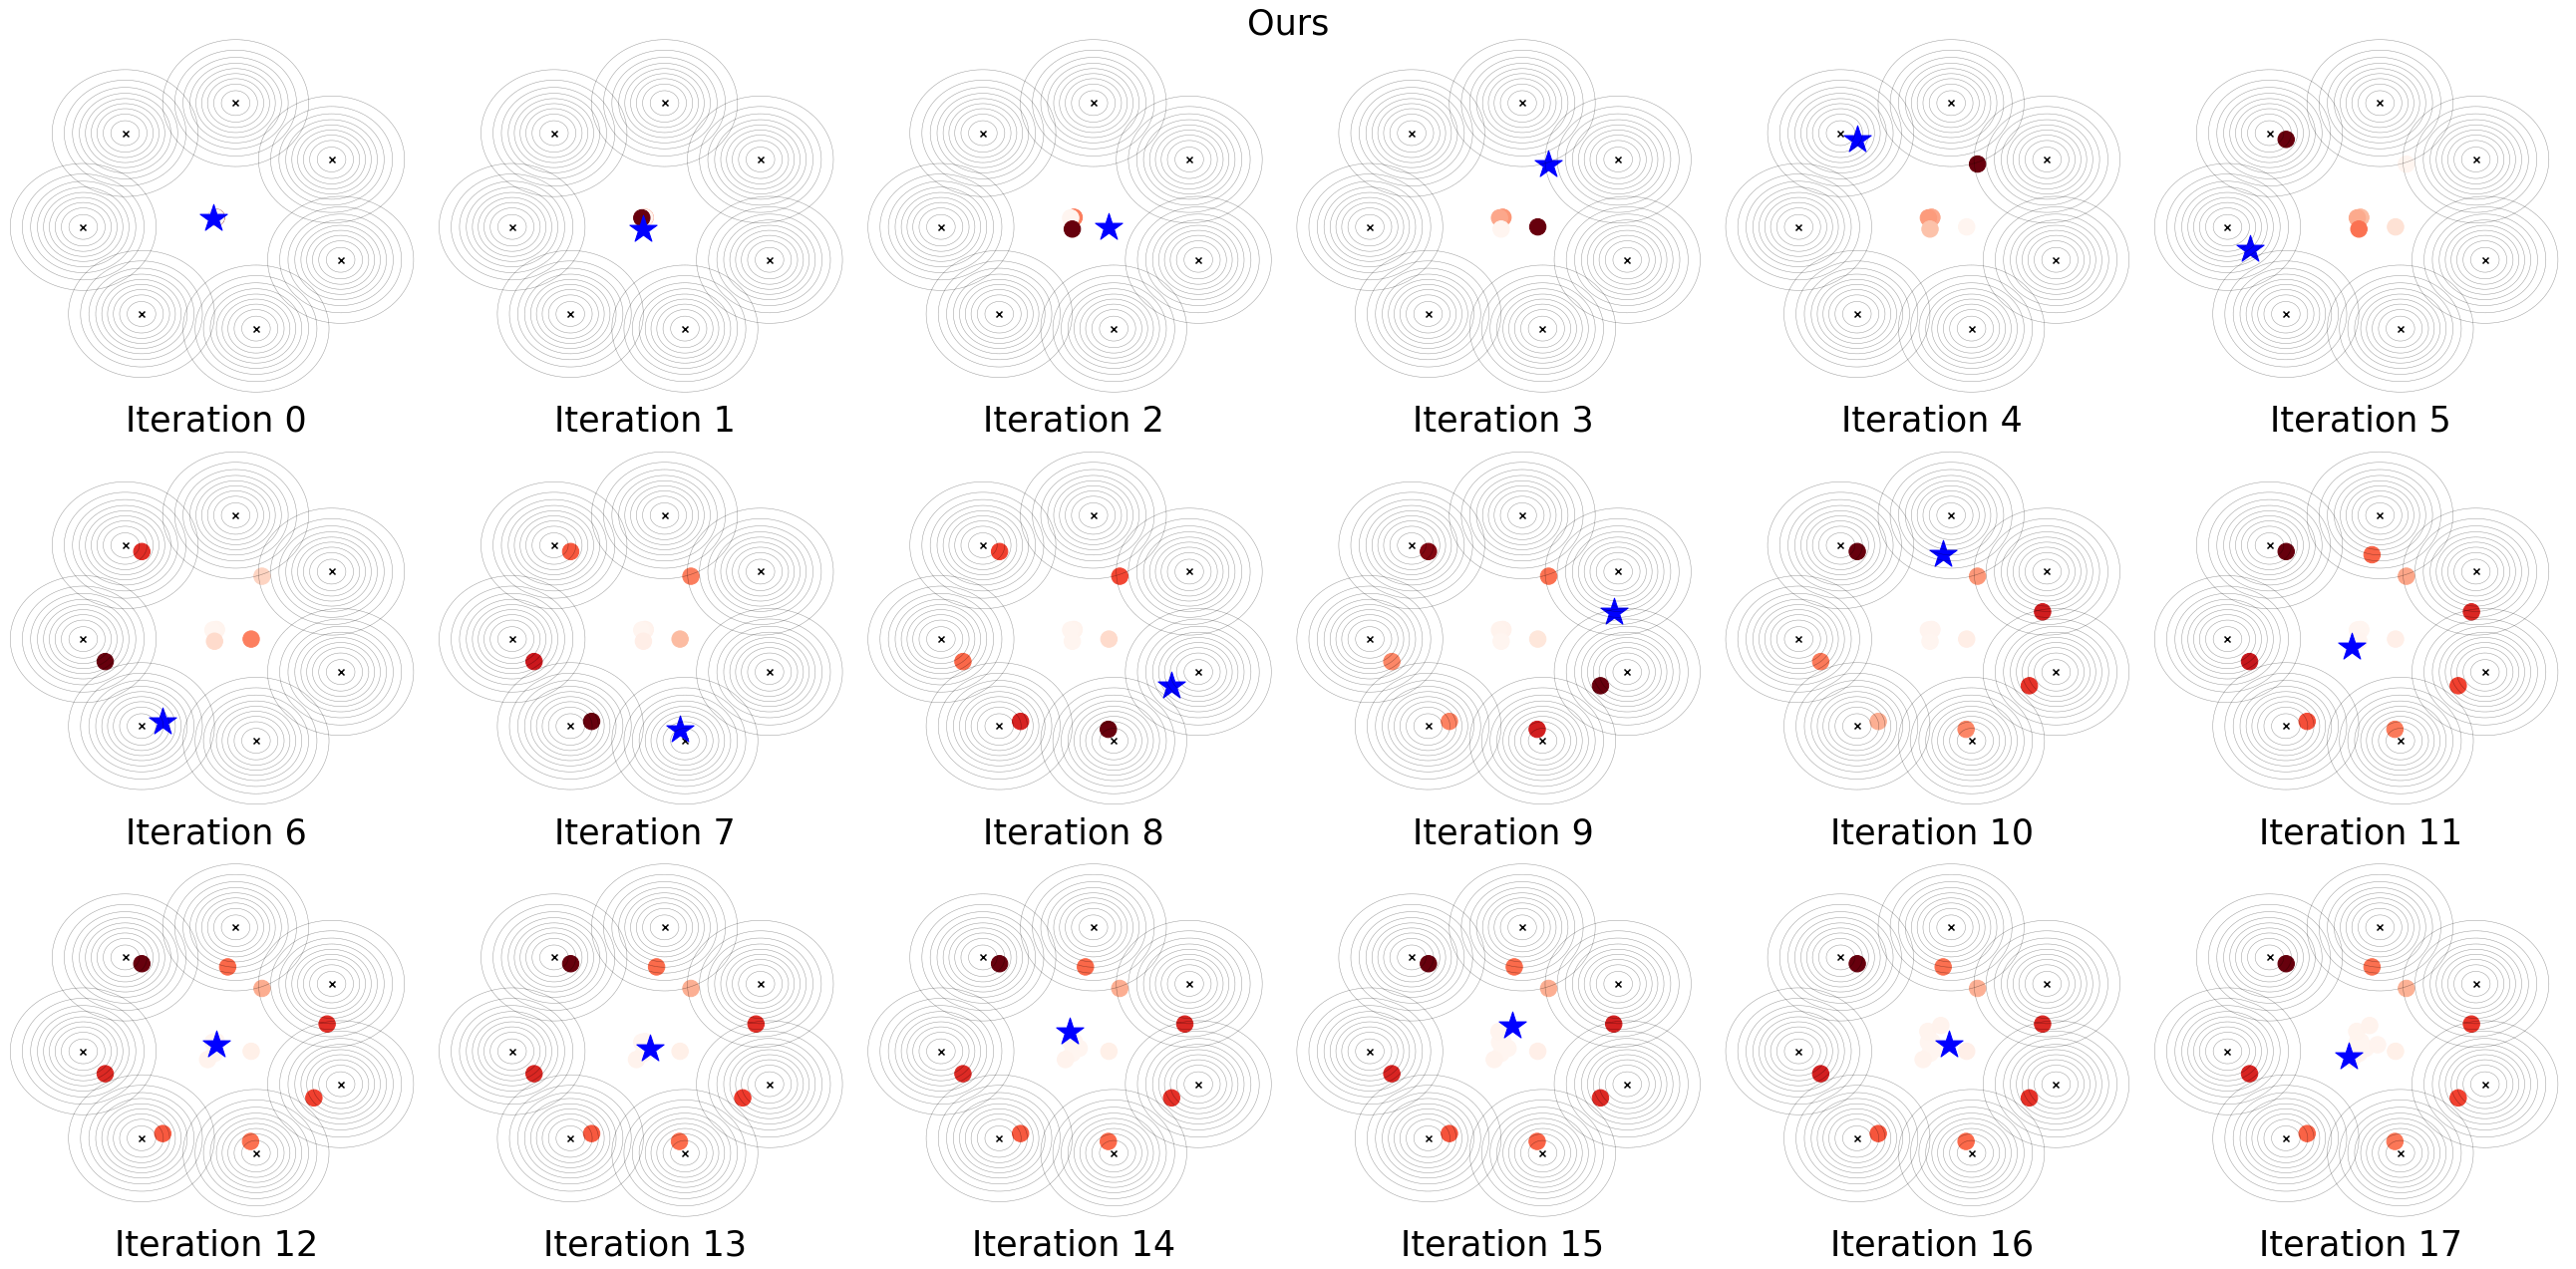

In [8]:
fig, axlist = plt.subplots(3, 6, figsize=(36,18))
iteration = [i for i in range(18)]#[1,4,7,10,13,16]
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2 * np.pi) ** n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos - mu, Sigma_inv, pos - mu)
    return np.exp(-fac / 2) / N

def draw(iters, ax):
    for i in range(7):
        ax.scatter(torch_pop.mus[i, 0].item(), torch_pop.mus[i, 1].item(), marker='x', c='k')
        for j in range(4):
            delta = 0.025
            x = np.arange(-4.5, 4.5, delta)
            y = np.arange(-4.5, 4.5, delta)
            X, Y = np.meshgrid(x, y)
            pos = np.empty(X.shape + (2,))
            pos[:, :, 0] = X
            pos[:, :, 1] = Y
            Z = multivariate_gaussian(pos, torch_pop.mus[i,:].cpu().numpy(), 0.54 * np.eye(2))
            levels = 10
            # levels = np.logspace(0.01, 1, 10, endpoint=True)
            CS = ax.contour(X, Y, Z, levels, colors='k', linewidths=0.5, alpha=0.1)
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
                # ax.clabel(CS, fontsize=9, inline=1)
                # circle = plt.Circle((0, 0), 0.2, color='r')
                # ax.add_artist(circle)
        ax.set_xlim([-4.5, 4.5])
        ax.set_ylim([-4.5, 4.5])
    label = 'timestep {0}'.format(iters)
    length = len(meta_nash_list[iters])
    agents = [agent.x.detach().cpu().numpy() for agent in torch_pop.pop[:length]]
    agents = list(zip(*agents))
    
    agents_new = [torch_pop.pop[length].x.detach().cpu().numpy()]
    agents_new = list(zip(*agents_new))
    # 更新线和坐标轴标签
    b = ax.scatter(agents[0], agents[1], alpha=1, marker='.', c=meta_nash_list[iters], cmap=plt.get_cmap('Reds'),  s=30*plt.rcParams['lines.markersize'] ** 2)
    #plt.colorbar(b)
    ax.scatter(agents_new[0], agents_new[1], alpha=1, marker='*', c='Blue',  s=23*plt.rcParams['lines.markersize'] ** 2)

    ax.set_xlabel('Iteration'+' '+str(iters), fontsize=35)

for i in range(len(axlist.flatten())):
    ax = axlist.flatten()[i]
    draw(iteration[i],ax)
fig.suptitle('Ours',fontsize=35)
fig.tight_layout()
plt.savefig('./auto_2d_rps_all.pdf',bbox_inches="tight", pad_inches=0.04)
plt.show()